In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
from explainabilityModels import make_gradcam_heatmap as GradCam

In [46]:
from tensorflow.keras.utils import image_dataset_from_directory

model = tf.keras.models.load_model("models/cells/model40")
test_dir = "cell_images/test/"
test_dataset = image_dataset_from_directory(
                test_dir,
                labels = "inferred",
                seed = 42,
                image_size = (128,128),
                batch_size = 64,
                shuffle = False
                )

x = test_dataset.unbatch()
imgs = np.array(list(x.map(lambda x, y: x)))
labels = np.array(list(x.map(lambda x, y: y)))

Found 2600 files belonging to 2 classes.


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

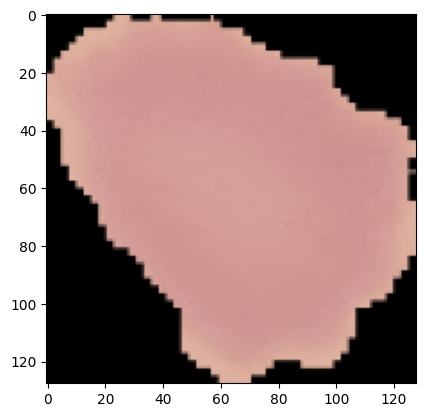

In [54]:
plt.imshow(imgs[-10].astype('uint8'))
labels[-10:]

In [55]:
#make gradcam heatmap for every image and normalise
heatmaps = np.zeros([imgs.shape[0], imgs.shape[1], imgs.shape[2]])

for img in range(imgs.shape[0]):
    heatmaps[img, :, :] = GradCam(imgs[img, :, :, :], model, pred_index=0)
    heatmaps[img, :, :] /= 255


In [191]:
from sklearn.datasets import make_blobs
from sklearn import mixture
from skimage.morphology import opening, disk, square
from tqdm import tqdm

segmentatons = np.zeros_like(heatmaps)
#region_means = np.zeros([imgs.shape[0], 4, 3])
for img in tqdm(range(imgs.shape[0])):
    v_I = np.reshape(imgs[img, :,:,:],(imgs[img, :,:,:].shape[0]*imgs[img,:,:,:].shape[1],imgs[img,:,:,:].shape[2]))
    gmm_win = mixture.GaussianMixture(n_components=5,covariance_type='full').fit(v_I)

    # mean_list = []
    # for mean in gmm_win.means_:
    #     if mean[0] >= 1e-5:
    #         mean_list.append(mean)
    # mean_list = np.array(mean_list)
    

    # region_means[img] = mean_list
    v_I_gmm = gmm_win.predict(v_I)
    I_gmm = np.reshape(v_I_gmm,[imgs[img,:,:,:].shape[0],imgs[img,:,:,:].shape[1]])
    opened = opening(I_gmm, disk(4))
    segmentatons[img,:,:] = opened

100%|██████████| 2600/2600 [08:00<00:00,  5.41it/s]


In [193]:
with open("segmentatons.npy", 'wb') as f:
    np.save(f, segmentatons)

# with open("region_means.npy", 'wb') as f:
#     np.save(f, region_means)


array([[213.2742164 , 145.05126103, 148.62750485],
       [200.71057599, 112.77703412, 149.90634946],
       [116.00932523,  67.15104341,  79.38121822],
       [195.54450057,  80.56225949, 143.4487791 ]])

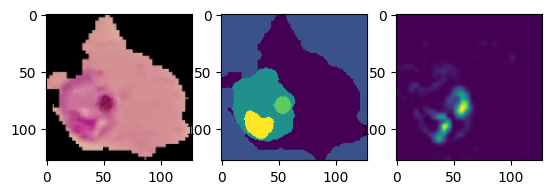

In [168]:
idx = -0
fig,ax = plt.subplots(1,3)
ax[0].imshow(imgs[idx].astype('uint8'))
ax[1].imshow(segmentatons[idx])
ax[2].imshow(heatmaps[idx])


In [205]:
from skimage.measure import regionprops_table
import plotly.express as px
t = np.copy(segmentatons[1].astype('uint8'))
y = np.copy(imgs[0].astype('uint8'))
if t[0][0] != 0:
    t[t==0] = (np.unique(t)[-1] + 1)
    t[t==t[0][0]] = 0

print(np.unique(t))

#t[t==0] = 4
props = pd.DataFrame(regionprops_table(t, properties=['area']))
print(props)
px.imshow(t)

[0 1 3]
    area
0  11146
1    289


In [ ]:
#find number of blobs in all images
num_blobs_array = []
for img in range(N):
    num_blobs_array.append(np.unique(region_imgs[:,:,img]).shape[0] - 1)

num_blobs = sum(num_blobs_array)
num_blobs

68897

In [13]:
num_blobs//imgs.shape[-1]

68

In [14]:
#generate interpretability scores for each blob; score is the sum of intensities of heatmap in the region
#plus get the highest score for every image
scores = np.zeros(num_blobs)
i = 0
highscores = []
for img in range(N):
    img_highscore = 0
    for region in np.unique(region_imgs[:,:,img]):   
        if region != 0:
            x = np.copy(region_imgs[:,:,img])
            x[x != region] = 0
            x[x == region] = 1
            img_score = np.mean((heatmaps[:,:,img] * x))
            scores[i] = img_score
            if img_score > img_highscore:
                img_highscore = img_score
            i += 1
    highscores.append(img_highscore)
        

In [15]:
highscores = np.asarray(highscores)
ind = np.where(np.in1d(scores, highscores))[0]
ind.shape

(1000,)

In [16]:
blob_areas = []
blob_eccentricities = []
blob_eq_areas = []
for img in range(N):
    areas = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['area'])).to_numpy().squeeze()
    eccentricities = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['eccentricity'])).to_numpy().squeeze()
    eq_areas = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['equivalent_diameter_area'])).to_numpy().squeeze()
    blob_areas += areas.tolist()
    blob_eccentricities += eccentricities.tolist()
    blob_eq_areas += eq_areas.tolist()

blob_areas = np.asarray(blob_areas)
blob_eccentricities = np.asarray(blob_eccentricities)
blob_eq_areas = np.asarray(blob_eq_areas)
blob_areas.shape

(68897,)

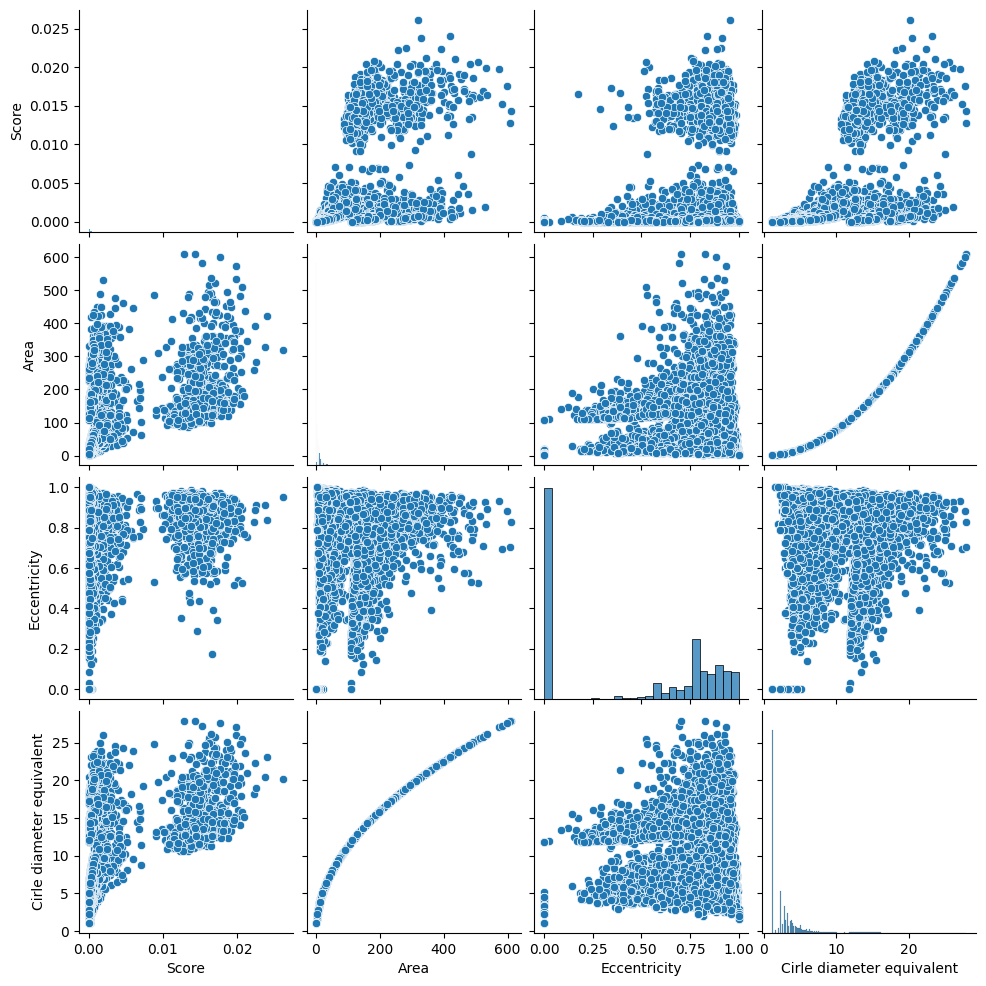

In [17]:
from seaborn import pairplot
data = pd.DataFrame({'Score': scores, 
                        'Area': blob_areas,
                        'Eccentricity': blob_eccentricities,
                        'Cirle diameter equivalent': blob_eq_areas})

pairplot(data)


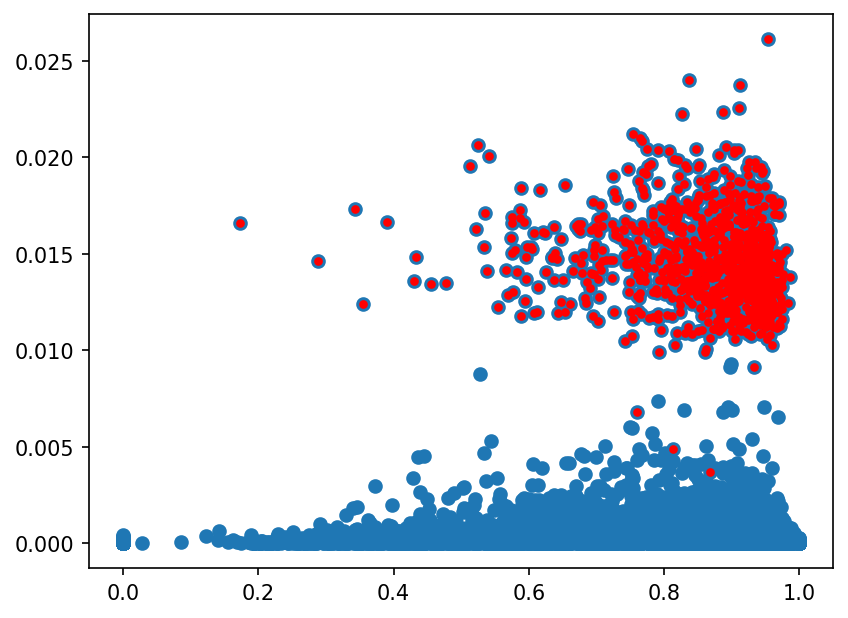

In [21]:
y = scores[ind]
x = blob_eccentricities[ind]
fig= plt.figure()
fig.set_dpi(150)
plt.scatter(blob_eccentricities, scores)
plt.scatter(x,y, s = 10, c = 'r')

0.0006558663785578495

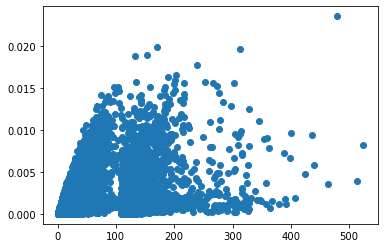

In [159]:
fig = plt.figure()
plt.scatter(np.delete(blob_areas, ind), np.delete(scores, ind))
np.mean(np.delete(scores, ind))

In [142]:
quant = np.quantile(scores, 1 - 1/40)
z = np.where(scores > quant)[0]
y = scores[z]
x = blob_areas[z]
fig = plt.figure()
fig.set_dpi(200)
plt.scatter(blob_areas, scores)
plt.scatter(x,y, s = 10,  c='r')

In [24]:
import plotly
import plotly.express as px

df = pd.DataFrame(data=np.vstack((blob_eccentricities, scores)).T, columns=['area', ' score'])
px.scatter(data_frame=df, x = df.columns[0], y = df.columns[1])


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'area=%{x}<br> score=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'x': array([0.94859013, 0.88433849, 0.81729842, ..., 0.        , 0.        ,
                          0.79056942]),
              'xaxis': 'x',
              'y': array([1.46484375e-04, 2.01056985e-05, 1.81908701e-04, ..., 3.82965686e-06,
                          1.91482843e-06, 7.65931373e-06]),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'area'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': ' score'}}}
})

In [144]:
from mpl_toolkits.mplot3d import Axes3D
x = blob_areas
y = blob_eccentricities
z = scores
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x,y,z)

ax.set_xlabel('Area')
ax.set_ylabel('Eccentricity')
ax.set_zlabel('Score')

C:\Users\William\AppData\Local\Temp\1\ipykernel_4632\2958983600.py:6: MatplotlibDeprecationWarning:

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.



Text(0.5, 0, 'Score')

In [29]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.vstack((blob_eccentricities, blob_areas))
X = np.transpose(X)
y = scores

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)





In [26]:
#build regression tree
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=3)
regressor = regressor.fit(X_train, y_train)

In [27]:
from sklearn.tree import plot_tree
plt.figure(figsize=(30,16))
plot_tree(regressor, max_depth=3, feature_names=['Eccentricity', 'Area'], filled=True, fontsize=8, precision=5)
plt.show()


(13780,) (13780, 2)


ValueError: x and y must be the same size

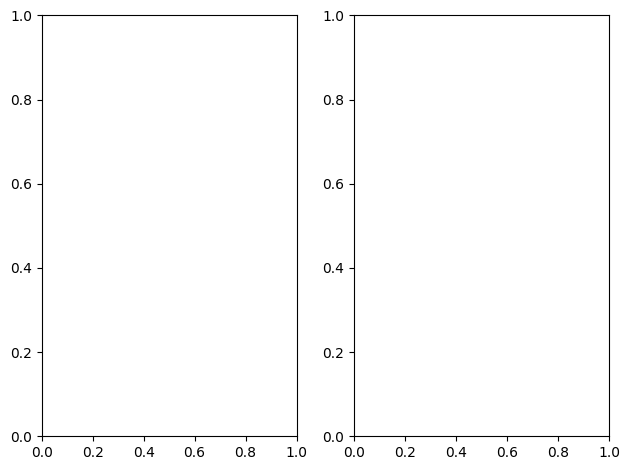

In [30]:
fig, ax = plt.subplots(1,2)
fig.tight_layout()
pred = regressor.predict(X_test)
ax[0].scatter(X_test, pred)
ax[0].set_title("Fitted Set")
ax[1].scatter(X_test, y_test)
ax[1].set_title("Test Set")

ValueError: x and y must be the same size

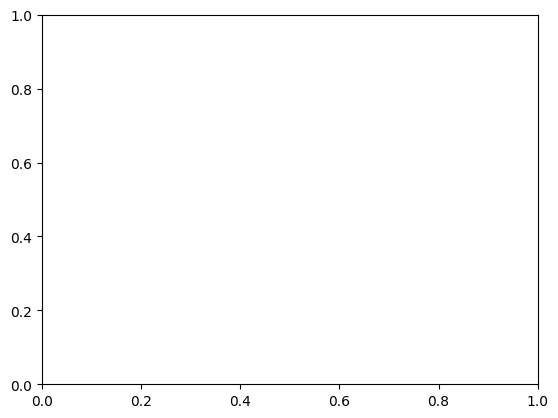

In [31]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

pred = lin_reg.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, pred, c = 'black')

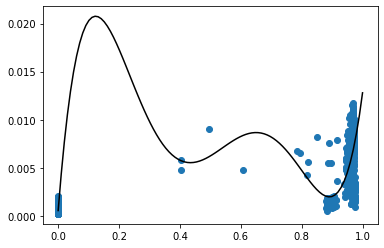

In [26]:
#polynomial fit with degree = 2
model = np.poly1d(np.polyfit(X_train.squeeze(), y_train, 5))

#add fitted polynomial line to scatterplot
polyline = np.linspace(0, 1, 100)
plt.scatter(X_train, y_train)
plt.plot(polyline, model(polyline), c = 'black')
plt.show()

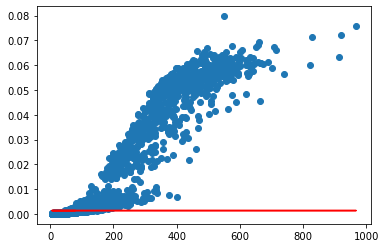

In [285]:
from scipy.optimize import curve_fit
def sigmoid(x, b, a):
    return 1.0/(1.0 + np.exp(-a*(x-b)))
bounds = ([200, 0.], [400, 0.005])
p0 = [300., 0.00001]
popt, pcov = curve_fit(sigmoid, X_train.squeeze() , y_train, method = 'dogbox')
plt.scatter(X_train, y_train)
plt.plot(X_train.squeeze(), sigmoid(X_train.squeeze(), *popt), c = 'r')